# Simulating Vibratory Systems with Non-Linearities

## Introduction

In this notebook, we'll explore numerically simulating the motion of **non-linear** systems for which we can't (or can't easily) derive the exact solutions analytically. After completing the notebook, you will be able to:

- Manipulate second-order differential equations (equations of motion) to obtain corresponding *systems of first-order differential equations*
- Become familiar with the programming interface for numerically integrating systems of first-order ODEs
- Simulate the free response of systems with non-linear characteristics

### Systems of First-Order ODEs

To simulate non-linear vibratory systems, we manipulate the equation(s) of motion into a specific form that allows generic numerical integration routines to work. This is achieved by selecting *state variables* for which we can write first-order ODEs corresponding to the equations of motion. That is, the goal is to write a system of first-order differential equations of the form:

$$\begin{align} \dot{x}_1 &= f(x_1,\, x_2,\, \ldots) \\ \dot{x}_2 &= g(x_1,\, x_2,\, \ldots) \\ \vdots \end{align}$$

When we derive the equations of motion using the Newton-Euler method, we get second-order differential equations. For one-dimensional motion, a simple choice of variables is $x_1 = x$ (position) and $x_2 = \dot{x}$ (velocity). Then we get $\dot{x}_1 = x_2$ and $\dot{x}_2 = \ddot{x}$, so we can write our system of equations as

$$\begin{align} \dot{x}_1 &= x_2 \\ \dot{x}_2 &= \frac{1}{m} \sum F \end{align}$$

The first equation is trivial (because of our selection of state variables), and the second equation is just $F = ma$.

### Numerically Integrating First-Order ODEs

In our code, we define a Python function that takes:

- the current values of our state variables ($x_1,\, x_2,\, \ldots$) in an array
- the current time value
- (optional) additional parameters such as masses, spring constants, etc.

The function uses these inputs to compute the derivatives of the state variables $\left(\dot{x}_1(t),\,\dot{x}_2(t),\,\ldots)\right)$ and return them. This function is passed to an ordinary differential equation solver with the initial conditions and an array of time values, and the solver repeatedly runs our function and numerically integrates to evaulate the state variables at the requested time points.

### Example: Linear mass-spring-damper system

As an example, let's simulate the mass-spring-damper system with linear spring and damping elements. The equation of motion is:

$$m\ddot{x} + c\dot{x} + k x = 0$$

Since we're dealing with 1D motion, our selection of state variables is straightforward: $x$ (position) and $v = \dot{x}$ (velocity). In this case, our state equations are:

$$\begin{align} \dot{x} &= v \\ \dot{v} &= -\frac{k}{m}x - \frac{c}{m} v \end{align}$$

Let's start with some imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def _rk4(t, dt, x, f, args=None):
    """4th-order Runge-Kutta integration step."""
    x = np.asarray(x)
    k1 = np.asarray(f(x, t, *args))
    k2 = np.asarray(f(x + 0.5*dt*k1, t + 0.5*dt, *args))
    k3 = np.asarray(f(x + 0.5*dt*k2, t + 0.5*dt, *args))
    k4 = np.asarray(f(x + dt*k3, t + dt, *args))
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0


def rk4int(func, x0, t, args=None):
    """4th-order Runge-Kutta integration.

    Parameters
    ----------
    func : callable(x, t, *args)
        Function that returns the derivatives of the state variables at time t.
    x0 : array_like, shape(n,)
        Initial values of the state variables.
    t : array, shape(m,)
        Array of time values at which to solve.
    args : tuple, optional
        Additional arguments to `func`.

    Returns
    -------
    x : ndarray, shape(m, n)
        Array containing the values of the state variables at the
        specified time values in `t`.

    """
    x = np.zeros((len(t), len(x0)))
    x[0, :] = x0
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        x[i] = _rk4(t[i], dt, x[i-1], func, args)
    return x

Now let's write the function that returns the derivatives of the state variables. The function takes the current values of the state variables (as an array), the current time, and any additional parameters we need (system parameters $m$, $k$, and $c$).

In [3]:
def msd_eqns(current_state, time, m, k, c):
    """Equations for a linear mass-spring-damper system"""
    # unpack the state variables array
    x, v = current_state
    
    # compute the derivatives
    xdot = v
    vdot = -(k/m)*x - (c/m)*v
    
    # pack the state derivatives together to return (same order as current_state!)
    state_derivative = xdot, vdot
    
    return state_derivative

Now we can use an integration routine (here we'll use the Runge-Kutta method provided as `rk4int`) to integrate the equations we specified at a set of time values. Here's what `rk4int` expects:

In [4]:
help(rk4int)

Help on function rk4int in module __main__:

rk4int(func, x0, t, args=None)
    4th-order Runge-Kutta integration.
    
    Parameters
    ----------
    func : callable(x, t, *args)
        Function that returns the derivatives of the state variables at time t.
    x0 : array_like, shape(n,)
        Initial values of the state variables.
    t : array, shape(m,)
        Array of time values at which to solve.
    args : tuple, optional
        Additional arguments to `func`.
    
    Returns
    -------
    x : ndarray, shape(m, n)
        Array containing the values of the state variables at the
        specified time values in `t`.



So we set things up by specifying the system parameters ($m$, $k$, and $c$), initial values of the state variables (position and velocity), and an array of time values to simulate over. Each state variable is then a column of the output of `rk4int`.

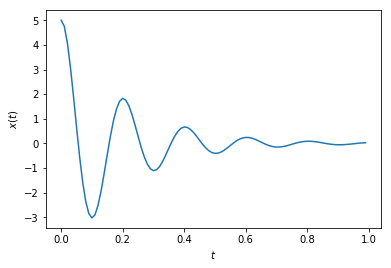

In [5]:
# parameters
m = 1
k = 1000
c = 10

# initial conditions
x0 = 5
v0 = 0

# array of time values
t = np.arange(0, 1, 0.01)

# call integration routine       
state_trajectory = rk4int(msd_eqns, [x0, v0], t, args=(m, k, c))
#                         |         |         |  |
#                         |         |         |  |_additional parameters for msd_eqns
#                         |         |         |
#                         |         |         |_time array
#                         |         |
#                         |         |_initial conditions
#                         |
#                         |_function returning state variable derivatives

# unpack the columns of the state variable array
x = state_trajectory[:, 0]
v = state_trajectory[:, 1]

plt.plot(t, x)
plt.xlabel('$t$')
plt.ylabel('$x(t)$')

## Exercise 1: Coulomb Friction

A common source of nonlinearity is Coulomb friction, which is specific type of damping. In viscous damping, there is a force that is linearly proportional to the velocity:

$$F_v = c \dot{x}$$

This simple source of energy dissipation allows us to derive the exact solution to the equations of motion for a mass-spring-damper system. With Coulomb friction, the damping force takes the form:

$$F_c = \begin{cases} -\mu N & \dot{x} > 0 \\ 0 & \dot{x} = 0 \\ \mu N & \dot{x} < 0 \end{cases}$$

where $\mu$ is the coefficient of sliding friction and $N$ is the normal force. Here the damping force is constant, always working against the motion of the system.

The form of the equation of motion is the same as in the linear damping case, where we have

$$m \ddot{x} + F_{\text{damping}} + F_{\text{spring}} = 0$$

But now the equation will have a nonlinearity because the damping force depends on the sign of $\dot{x}$:

$$m \ddot{x} + \mu m g \,\text{sgn}\left( \dot{x} \right) + kx = 0$$

Fill in the function definition below to compute the derivatives of the state variables $x$ and $v = \dot{x}$.

In [6]:
def coulomb_eqns(state_vars, t, m, k, mu):
    """Returns the derivative of the states.
    
    Parameters
    ==========
    state_vars : array_like, shape(n,)
        A 1D array containing the current state values.
    t : float
        A value for the current time.
    m : float
        A value for the mass.
    k : float
        A value for the stiffness.
    mu : float
        A value for the coefficient of kinetic friction.
        
    Returns
    =======
    xdot : ndarray, shape(n,)
        The derivative of the states at the current time.
    """
    x, v = state_vars
    
    xdot = v
    vdot = -mu*9.81*np.sign(v) - (k/m)*x
    
    return xdot, vdot

Use the function above to simulate a mass-spring system with Coulomb friction using the following parameters:

- $m = 1000$ kg
- $k = 5000$ N/m
- $\mu = 0.2$
- duration: 10 seconds

Use zero initial velocity and plot the position of the mass for two different initial positions: 5 m and 4.5 m. Add a grid to the plot and take note of where the system comes to rest.

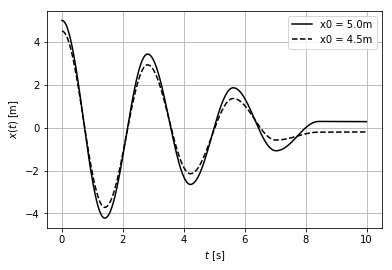

In [7]:
# system parameters
m = 1000 # mass [kg]
k = 5000 # spring stiffness [N/m]
mu = 0.2 # coulomb friction coefficient
d = 10   # duration [s]

# initial conditions
xinits = np.array([[5, 0],    # simulation 1
                   [4.5, 0]]) # simulation 2
linestyles = ['-', '--']

# time array with a fairly small time step
t = np.arange(0, 10, 0.01)

for (x0, v0), linestyle in zip(xinits, linestyles):
    state_trajectory = rk4int(coulomb_eqns, [x0, v0], t, args=(m, k, mu))
    x = state_trajectory[:, 0]
    v = state_trajectory[:, 1]
    plt.plot(t, x, linestyle=linestyle,
             color='k', label="x0 = {:.1f}m".format(x0))
    
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$x(t)$ [m]')
plt.legend()
plt.grid()

## Questions

1) This system behaves similiarly to a vicously damped system, but there are some differences. What differences can you find when exploring the simulation? Think about how the oscillation decays over time and any unexpected behavior. You may want to plot both state variables to see more information. Describe these differences in the cell below.

2) With $v_0=0$ try to find the value of $x_0$ that bounds the equilibrium range by simulating the system with various initial positions. What is the significance of this boundary? What does it represent?

## Exercise 2: Pendulum

In class, we've looked at the simple pendulum, which has the following equation of motion:

$$\ddot{\theta} + \frac{g}{l} \sin \theta = 0$$

To solve the equation of motion for this system, we linearized to get rid of a $\sin\theta$ term. This was done by noting that for small angles, $\sin\theta \approx \theta$. With this approximation, we find that the system oscillates at a natural frequency of $\omega_n = \sqrt{\frac{g}{l}}$. Let's see what happens if we do not make the small angle approximation.

Start by writing the function to return the (non-linear) derivatives of the state variables $\theta$ and $\omega = \dot{\theta}$.

In [8]:
def pend_eqns(state_vars, t, l, g):
    """Returns the derivative of the states.
    
    Parameters
    ==========
    state_vars : array_like, shape(n,)
        A 1D array containing the current state values: theta and omega.
    t : float
        A value for the current time.
    l : float
        A value for the length of the pendulum.
    g : float
        A value for the acceleration due to gravity.
        
    Returns
    =======
    xdot : ndarray, shape(n,)
        The derivative of the states at the current time, i.e. theta' and omega'.
    
    """
    theta, omega = state_vars
    
    thetadot = omega
    omegadot = - g / l * np.sin(theta)
    
    return thetadot, omegadot

Use `interact` to plot $\theta(t)$ such that you can interactively manipulate the initial angle between 0 and 90 degrees (use zero initial velocity). Use a value of $l$ which makes the linearized system oscillate at 1 Hz and simulate for 4 seconds.

In addition to the response of the non-linear system, plot the response of the linearized system as well. Since we're using zero initial velocity, you may use the following equation to compute the response of the linearized system:

$$\theta_l(t) = \theta_0 \cos\left(\sqrt{\frac{g}{l}} t\right)$$

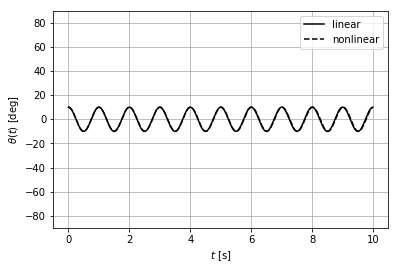

<function __main__.simulate>

In [9]:
from ipywidgets import interact

# gravitational constant
g = 9.81
# oscillation frequency in Hz
f = 1

# convert frequency to rad/s
omega_n = 2 * np.pi * f
# compute length to get desired natural frequency
l = g / omega_n**2

t = np.arange(0, 10, 0.01)

def simulate(ang_init=10):
    # linearized response
    theta_lin = ang_init * np.cos(np.sqrt(g / l)*t)
    
    # non-linear response
    x = rk4int(pend_eqns, [np.deg2rad(ang_init), 0], t, args=(l, g))
    x = np.rad2deg(x)
    theta_nonlin = x[:, 0]
    
    plt.plot(t, theta_lin, color='k', linestyle='-', label='linear')
    plt.plot(t, theta_nonlin, color='k', linestyle='--', label='nonlinear')
    plt.ylim(-90, 90)
    plt.xlabel(r'$t$ [s]')
    plt.ylabel(r'$\theta(t)$ [deg]')
    plt.legend()
    plt.grid()

interact(simulate, ang_init=(0, 90, 5))

## Question

Describe what happens when the initial angle is large, i.e. when the small angle approximation no longer holds?

# Exercise 3: Unstable Pendulum

In class we derived the non-linear and linear equations of motion for a pendulum that was held veritcal by two springs in series. We predicted that it would be unstable if:

$$
\frac{k}{2 m} < \frac{g}{l}
$$

Here is the second order non-linear equation of motion:

$$
g l m \operatorname{sin}\left(\theta\right) - \frac{k l^{2}}{2} \operatorname{sin}\left(\theta\right) \operatorname{cos}\left(\theta\right) - l^{2} m \ddot{\theta} = 0
$$

Simulate this non-linear system along with the linear system using $m = 1.0, l=1.0, g=9.81$ and various values of $k$ that will cause the system to be stable and/or unstable. Initial conditions can be $\theta=\pi/10,\dot{\theta}=0$.

In [10]:
def unstable_pend_eqns(state_vars, t, m, l, g):
    """Returns the derivative of the states.
    
    Parameters
    ==========
    state_vars : array_like, shape(n,)
        A 1D array containing the current state values: theta and omega.
    t : float
        A value for the current time.
    m : float
        A value for the mass of the pendulum.
    l : float
        A value for the length of the pendulum.
    g : float
        A value for the acceleration due to gravity.
        
    Returns
    =======
    xdot : ndarray, shape(n,)
        The derivative of the states at the current time, i.e. theta' and omega'.
    
    """
    theta, omega = state_vars
    
    thetadot = omega
    omegadot = (1 / m*l**2) * \
        (g*l*m*np.sin(theta) - 0.5*k*l**2*np.sin(theta)*np.cos(theta))
    
    return thetadot, omegadot

Here we'll just set up the system parameters.

In [11]:
m = 1.0  # mass [kg]
l = 1.0  # length [m]
g = 9.81 # gravitational constant

# intial conditions
theta_0 = np.pi / 10
omega_0 = 0

# array of time values to simulate over
t = np.arange(0, 10, 0.01)

Now we can specify some values of $k$ that will result in a stable and unstable system. To do this, we can use the stability criterion $\frac{k}{2 m} < \frac{g}{l}$ to find a critical value of $k_c = \frac{2mg}{l}$ with coefficients greater than or less than 1 to control whether or not the criterion holds.

We'll create a set of $k$ values for each condition (stable and unstable) and plot them on separate axes.

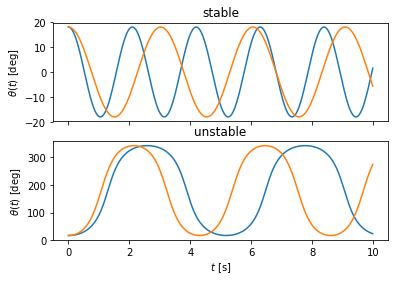

In [12]:
k_crit = 2 * m * g / l

k_stable = np.array([2, 1.5]) * k_crit
k_unstable = np.array([0.5, 0.1]) * k_crit

k_sets = [k_stable, k_unstable]
fig, axes = plt.subplots(nrows=2, sharex=True)
label = ['stable', 'unstable']

for k_set, ax, label in zip(k_sets, axes, label):
    for k in k_set:
        x = rk4int(unstable_pend_eqns, [theta_0, omega_0], t, args=(m, l, g))
        x = np.rad2deg(x)
        theta = x[:, 0]
        
        ax.set_title(label)
        ax.plot(t, theta)
        ax.set_ylabel(r'$\theta(t)$ [deg]')
        
axes[-1].set_xlabel(r'$t$ [s]')

## Question

1) Is the system unstable with specific values of $k$? If so what are those values?

2) Does this do what you expect it should do? Make sure to plot the state trajectories to see what is going on.